<a href="https://colab.research.google.com/github/uncertainity/Gyroscope_Sensor_Analysis/blob/main/Accelerometer_Sensor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten,Conv2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import RMSprop
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow_probability as tfp


In [2]:
tfd = tfp.distributions
tfpl = tfp.layers


In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
def load_file(filepath):
    dataframe = pd.read_csv(filepath,header = None, delim_whitespace = True)
    return dataframe.values

def load_group(filenames,prefix = ""):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    loaded = np.dstack(loaded)
    return loaded

#total_acc = load_group(filenames,prefix = prefix+ "Inertial Signals\\")
##/content/drive/MyDrive/HAR/test

In [5]:
def load_dataset(group,prefix = ""):
    filenames = list()
    filepath = prefix + group +   "/Inertial Signals/"
    filenames += ["total_acc_x_" +group + ".txt","total_acc_y_" + group + ".txt","total_acc_z_" + group + ".txt"]
    filenames += ["body_gyro_x_" + group + ".txt","body_gyro_y_" + group + ".txt","body_gyro_z_" + group + ".txt"]
    filenames += ["body_acc_x_" + group + ".txt","body_acc_y_"+ group + ".txt","body_acc_z_" + group + ".txt"]
    x = load_group(filenames,prefix = filepath)
    y = load_file(prefix + group + "/y_" + group + ".txt") - 1
    z = load_file(prefix + group + "/X_" + group + ".txt")
    return z,x,y

In [6]:
filenames = ["total_acc_x_train.txt","total_acc_y_train.txt","total_acc_z_train.txt"]
prefix = "/content/drive/MyDrive/HAR/"
z_train,x_train,y_train = load_dataset("train",prefix = prefix)
z_test,x_test,y_test = load_dataset("test",prefix = prefix)


print("training set dim:",(x_train.shape,y_train.shape))
print("testing set dim:",(x_test.shape,y_test.shape))


training set dim: ((7352, 128, 9), (7352, 1))
testing set dim: ((2947, 128, 9), (2947, 1))


In [7]:
def integer_to_onehot(data_integer):
    one_hot = tf.one_hot(data_integer,6).numpy()
    return np.squeeze(one_hot,axis = 1)
    
    

In [8]:
y_test_oh = integer_to_onehot(y_test)
y_train_oh = integer_to_onehot(y_train)

Example No: 0


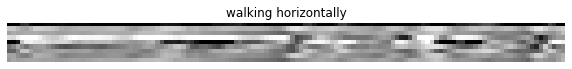

Example No: 1


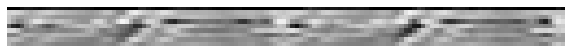

Example No: 2


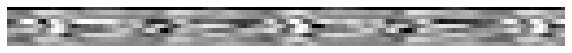

Example No: 3


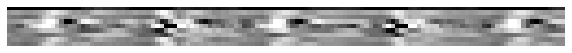

Example No: 4


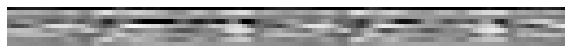

Example No: 0


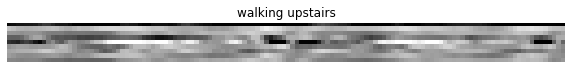

Example No: 1


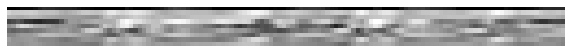

Example No: 2


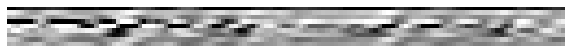

Example No: 3


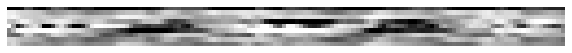

Example No: 4


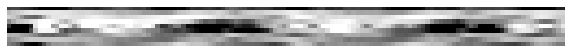

Example No: 0


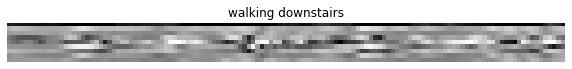

Example No: 1


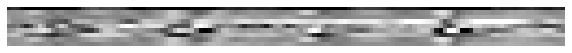

Example No: 2


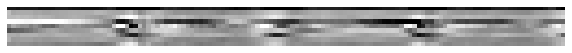

Example No: 3


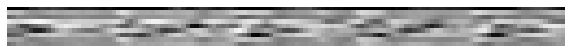

Example No: 4


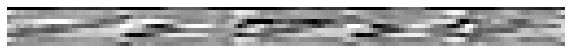

Example No: 0


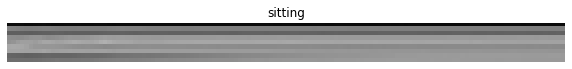

Example No: 1


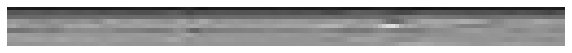

Example No: 2


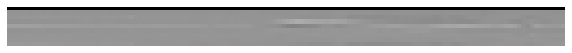

Example No: 3


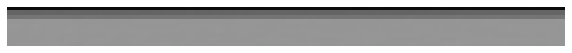

Example No: 4


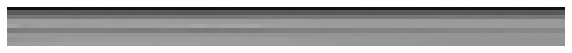

Example No: 0


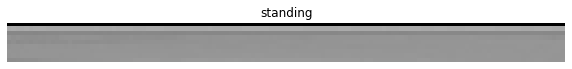

Example No: 1


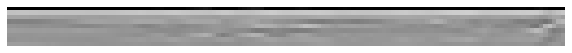

Example No: 2


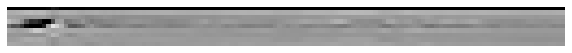

Example No: 3


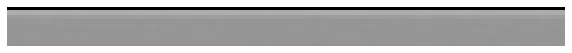

Example No: 4


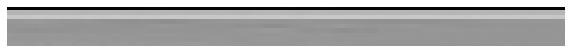

Example No: 0


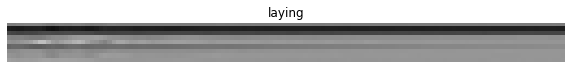

Example No: 1


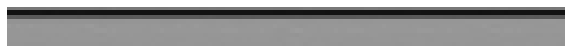

Example No: 2


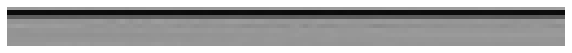

Example No: 3


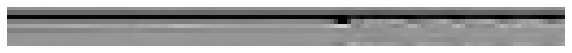

Example No: 4


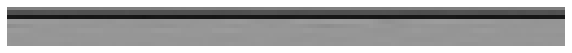

In [9]:
label_to_activity = {0: 'walking horizontally', 1: 'walking upstairs', 2: 'walking downstairs',
                     3: 'sitting', 4: 'standing', 5: 'laying'}
def make_plots(num_examples_per_category):
    for label in range(6):
        x_label = x_train[y_train[:, 0] == label]
        for i in range(num_examples_per_category):
            fig, ax = plt.subplots(figsize=(10, 1))
            ax.imshow(x_label[100*i].T, cmap='Greys', vmin=-1, vmax=1)
            ax.axis('off')
            if i == 0:
                ax.set_title(label_to_activity[label])
            print("Example No:",i)
            plt.show()
        
make_plots(5)

In [10]:
model1 = Sequential([
                    Conv1D(input_shape = (128,9),filters = 8, kernel_size = 16,activation = "relu"),
                    MaxPooling1D(pool_size = 16),
                    Flatten(),
                    Dense(units = 6,activation = "softmax")
])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 113, 8)            1160      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 7, 8)             0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 56)                0         
                                                                 
 dense (Dense)               (None, 6)                 342       
                                                                 
Total params: 1,502
Trainable params: 1,502
Non-trainable params: 0
_________________________________________________________________


In [11]:
divergence_fn = lambda q,p,_:tfd.kl_divergence(q,p)/x_train.shape[0]
model = Sequential([
                    tfpl.Convolution1DReparameterization(input_shape = (128,9),filters = 8, kernel_size =16,activation = "relu",
                    kernel_prior_fn = tfpl.default_multivariate_normal_fn, 
                    kernel_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular = False),
                    kernel_divergence_fn = divergence_fn,
                    bias_prior_fn = tfpl.default_multivariate_normal_fn,
                    bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular = False),
                    bias_divergence_fn = divergence_fn),
                    MaxPooling1D (pool_size = 16),
                    Flatten(),
                    tfpl.DenseReparameterization(units = tfpl.OneHotCategorical.params_size(6),activation = None,
                                                kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                                kernel_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular = False),
                                                kernel_divergence_fn  = divergence_fn,
                                                bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                                bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular = False),
                                                bias_divergence_fn  = divergence_fn),
                    tfpl.OneHotCategorical(6)
                    
])
model.summary()


/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_reparameterization (  (None, 113, 8)           2320      
 Conv1DReparameterization)                                       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 7, 8)             0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 56)                0         
                                                                 
 dense_reparameterization (D  (None, 6)                684       
 enseReparameterization)                                         
                                                                 
 one_hot_categorical (OneHot  ((None, 6),              0         
 Categorical)                 (None, 6))              

In [12]:
def nll(y_true,y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss = nll,optimizer = RMSprop(learning_rate = 0.005),metrics = ["accuracy"])


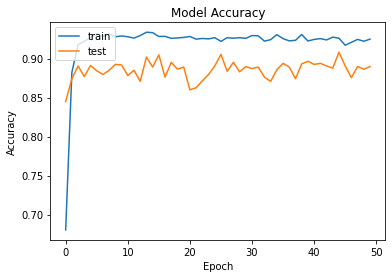

In [13]:

history = model.fit(x_train, y_train_oh, validation_split = 0.2,epochs=50, verbose=False)

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(['train', 'test'], loc='upper left')
plt.show()



In [14]:
model.evaluate(x_train, y_train_oh)
model.evaluate(x_test, y_test_oh)

93/93 [==============================] - 0s 3ms/step - loss: 1.1255 - accuracy: 0.8673


[1.1255295276641846, 0.8673226833343506]

In [15]:
def analyse_model_predictions(image_num):

    # Show the accelerometer data
    print('------------------------------')
    print('Accelerometer data:')
    fig, ax = plt.subplots(figsize=(10, 1))
    ax.imshow(x_test[image_num].T, cmap='Greys', vmin=-1, vmax=1)
    ax.axis('off')
    plt.show()

    # Print the true activity
    print('------------------------------')
    print('True activity:', label_to_activity[y_test[image_num, 0]])
    print('')

    # Print the probabilities the model assigns
    print('------------------------------')
    print('Model estimated probabilities:')
    # Create ensemble of predicted probabilities
    predicted_probabilities = np.empty(shape=(200, 6))
    for i in range(200):
        predicted_probabilities[i] = model(x_test[image_num][np.newaxis, ...]).mean().numpy()[0]
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(6)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(6)])
    # Make the plots
    fig, ax = plt.subplots(figsize=(9, 3))
    bar = ax.bar(np.arange(6), pct_97p5, color='red')
    bar[y_test[image_num, 0]].set_color('green')
    bar = ax.bar(np.arange(6), pct_2p5-0.02, color='white', linewidth=1, edgecolor='white')
    ax.set_xticklabels([''] + [activity for activity in label_to_activity.values()],
                       rotation=45, horizontalalignment='right')
    ax.set_ylim([0, 1])
    ax.set_ylabel('Probability')
    plt.show()

------------------------------
Accelerometer data:


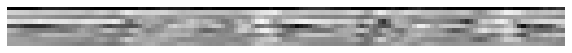

------------------------------
True activity: walking horizontally

------------------------------
Model estimated probabilities:


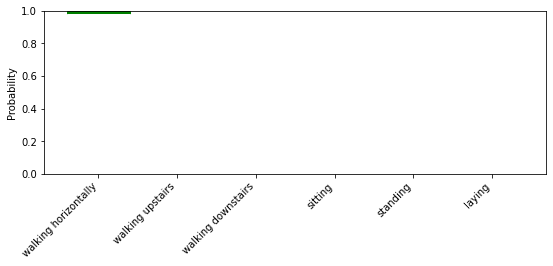

In [16]:
analyse_model_predictions(image_num = 79)